In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

# Network

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
# export
class VariableSoftmax(nn.Softmax):
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [7]:
x = torch.randn((1,10))

In [8]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[1.8700e-16, 3.0933e-07, 1.0000e+00, 2.1322e-12, 3.8444e-10, 3.6726e-11,
          5.4426e-12, 1.1859e-15, 3.9183e-09, 1.3330e-11]]),
 tensor([[6.4386e-04, 4.4927e-02, 9.0037e-01, 4.1705e-03, 1.1787e-02, 7.3691e-03,
          5.0302e-03, 9.3160e-04, 1.8752e-02, 6.0171e-03]]),
 tensor([[0.0144, 0.1204, 0.5388, 0.0367, 0.0616, 0.0487, 0.0403, 0.0173, 0.0778,
          0.0440]]))

In [9]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [10]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [11]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [12]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

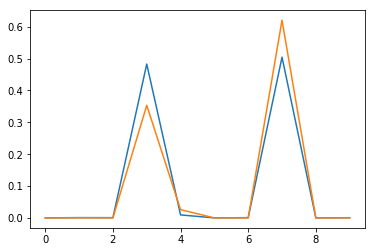

In [13]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

In [14]:
#export
class AbsInferno(AbsCallback):
    r'''Attempted reproduction of TF1 & TF2 INFERNO with exact effect of nuisances being passed through model
    Runs but doesn't reproduce paper results; values are off and display strong changes between benchmarks
    Includes option to randomise params per batch, but results in worse performance'''
    def __init__(self, n:int, true_mu:float, n_alphas:int=0, aug_alpha:bool=False):
        super().__init__()
        store_attr()
        self.true_b = self.n-self.true_mu
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
        self.alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)  #  Nuisances set to zero (true values)
        with torch.no_grad(): self.alpha[0] = self.true_mu  # POI set to true value
                
    def on_batch_begin(self) -> None:
        if self.aug_alpha:
            self.rand = torch.randn_like(self.alpha, device=self.wrapper.device)/10
            with torch.no_grad(): self.alpha += self.rand
        self.b_mask = self.wrapper.y.squeeze() == 0
        self.aug_data(self.wrapper.x)
    
    def on_batch_end(self) -> None:
        if self.aug_alpha:
             with torch.no_grad(): self.alpha -= self.rand
        self.alpha.grad.data.zero_()
    
    @abstractmethod
    def aug_data(self, x:Tensor) -> Tensor:
        r'''Include nuisances in input data. Overide this for specific problem.'''
        pass
    
    def get_inv_ikk(self, f_s:Tensor, f_b:Tensor) -> Tensor:
        r'''Compute full hessian at true param values'''
        nll = calc_nll(s_exp=self.alpha[0], alpha=self.alpha[1:], s_true=self.true_mu, b_true=self.true_b,
                       f_s=f_s, f_b_nom=f_b, f_b_up=None, f_b_dw=None)
        _,h = calc_grad_hesse(nll, self.alpha, create_graph=True)
#         print('hess', h)
#         print('inverse', torch.inverse(h))
#         print('reciprocal', 1/h)
        return torch.inverse(h)[0,0]
        
    def on_forwards_end(self) -> None:
        r'''Compute loss and replace wrapper loss value'''
        def to_shape(p:Tensor) -> Tensor:
            f = p.sum(0)+1e-7
            return f/f.sum()
        
        f_s = to_shape(self.wrapper.y_pred[~self.b_mask])
        f_b = to_shape(self.wrapper.y_pred[self.b_mask])
        self.wrapper.loss_val = self.get_inv_ikk(f_s=f_s, f_b=f_b)

#export
class PaperInferno(AbsInferno):
    r'''Inheriting class for dealing with INFERNO paper synthetic problem'''
    def __init__(self, float_r:bool, float_l:bool, l_init:float=3, n:int=1050, true_mu:int=50, aug_alpha:bool=False):
        super().__init__(n=n, true_mu=true_mu, n_alphas=float_r+float_l, aug_alpha=aug_alpha)
        self.float_r,self.float_l,self.l_init = float_r,float_l,l_init
        
    def aug_data(self, x:Tensor) -> None:
        if self.float_r: x[self.b_mask,0] += self.alpha[1]
        if self.float_l: x[self.b_mask,2] *= (self.alpha[-1]+self.l_init)/self.l_init

In [15]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [16]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=0, float_l=1, aug_alpha=False),LossTracker(),SaveBest('weights/best_ie1l.h5'),EarlyStopping(10)])

1: Train=431.0265689086914 Valid=367.14495666503905
2: Train=350.0036624145508 Valid=343.35707702636716
3: Train=337.1645803833008 Valid=334.353154296875
4: Train=328.7656726074219 Valid=327.61052856445315
5: Train=323.1232504272461 Valid=322.82330017089845
6: Train=318.57959625244143 Valid=319.05847595214846
7: Train=315.517001953125 Valid=316.08916748046875
8: Train=312.435009765625 Valid=312.46338134765625
9: Train=309.25285278320314 Valid=310.74473449707034
10: Train=306.8430291748047 Valid=307.81175231933594
11: Train=304.43395614624023 Valid=305.2183264160156
12: Train=302.43362396240235 Valid=303.0276068115234
13: Train=300.10110122680663 Valid=300.53399780273435
14: Train=297.96051467895506 Valid=299.6453076171875
15: Train=295.5270576477051 Valid=297.5752099609375
16: Train=294.0154196166992 Valid=295.5110559082031
17: Train=291.9388749694824 Valid=293.1948712158203
18: Train=289.2396575927734 Valid=291.41072235107424
19: Train=288.02729232788084 Valid=289.61280639648436
20: T

155: Train=241.93528015136718 Valid=246.75029541015624
156: Train=241.74268264770507 Valid=246.6842184448242
157: Train=241.99936294555664 Valid=246.4729327392578
158: Train=241.2651837158203 Valid=246.5611114501953
159: Train=241.62115859985352 Valid=246.31263610839844
160: Train=241.60683609008788 Valid=246.48624572753906
161: Train=241.46534225463867 Valid=246.62782531738281
162: Train=241.91315216064453 Valid=246.4464599609375
163: Train=241.51801208496093 Valid=246.48525024414062
164: Train=241.40865249633788 Valid=246.33763549804686
165: Train=241.22753234863282 Valid=246.51681610107423
166: Train=241.3941340637207 Valid=246.07002655029297
167: Train=241.17520202636717 Valid=246.17826934814454
168: Train=241.35307846069335 Valid=246.09318054199218
169: Train=241.27829681396486 Valid=246.2571337890625
170: Train=241.08778274536132 Valid=246.2357080078125
171: Train=241.33866012573242 Valid=245.88570678710937
172: Train=241.04064880371095 Valid=245.8607843017578
173: Train=241.0337

In [17]:
model.save('weights/Inferno_Test_exact_bm1l.h5')

In [18]:
model.load('weights/Inferno_Test_exact_bm1l.h5')

# Results

In [19]:
# export
class InfernoPred(PredHandler):
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)#/len(self.wrapper.model[-2].weight)

## BM 0

In [20]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [21]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,7,1.0
1,3,1.0
2,2,1.0
3,6,1.0
4,6,1.0


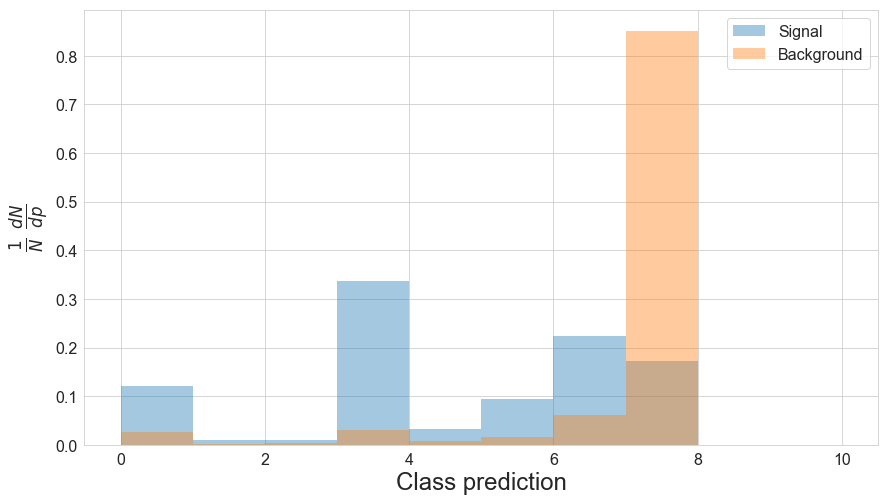

In [22]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [23]:
bin_preds(df)

In [24]:
df.head()

,pred,gen_target,pred_bin
0,7,1.0,7
1,3,1.0,3
2,2,1.0,2
3,6,1.0,6
4,6,1.0,6


In [25]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [26]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [27]:
f_s, f_b

(tensor([1.2013e-01, 9.5320e-03, 1.0066e-02, 3.3749e-01, 3.2948e-02, 9.3940e-02,
         2.2371e-01, 1.7219e-01, 2.0000e-13, 2.0000e-13]),
 tensor([2.5626e-02, 2.3980e-03, 2.9380e-03, 3.1330e-02, 8.5920e-03, 1.6738e-02,
         6.0726e-02, 8.5165e-01, 2.0000e-13, 2.0000e-13]))

In [28]:
asimov = (50*f_s)+(1000*f_b)

In [29]:
asimov, asimov.sum()

(tensor([3.1632e+01, 2.8746e+00, 3.4413e+00, 4.8204e+01, 1.0239e+01, 2.1435e+01,
         7.1911e+01, 8.6026e+02, 2.1000e-10, 2.1000e-10]), tensor(1050.))

In [30]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([22.54066467, 22.39519119, 22.25459671, 22.12080383, 21.99220657,
       21.8692646 , 21.7518959 , 21.64048004, 21.53355408, 21.43287849,
       21.33755493, 21.24692345, 21.16187668, 21.08147049, 21.00653076,
       20.93700027, 20.87192154, 20.81114578, 20.75563812, 20.70532036,
       20.65914917, 20.61806679, 20.58055878, 20.54902267, 20.52090454,
       20.49717331, 20.47826385, 20.46318626, 20.45327187, 20.44709778,
       20.44454193, 20.44661713, 20.45316315, 20.46278381, 20.47730255,
       20.49575806, 20.51713562, 20.54328346, 20.57275963, 20.60647964,
       20.6439209 , 20.68453789, 20.72929192, 20.77763748, 20.8295784 ,
       20.88497734, 20.94443512, 21.00634003, 21.07266235, 21.14232635,
       21.21492195, 21.29081345, 21.37050056, 21.45286942, 21.5390892 ,
       21.6279335 , 21.72049332, 21.81615067, 21.91491127, 22.01677132,
       22.12172318])

In [31]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [32]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

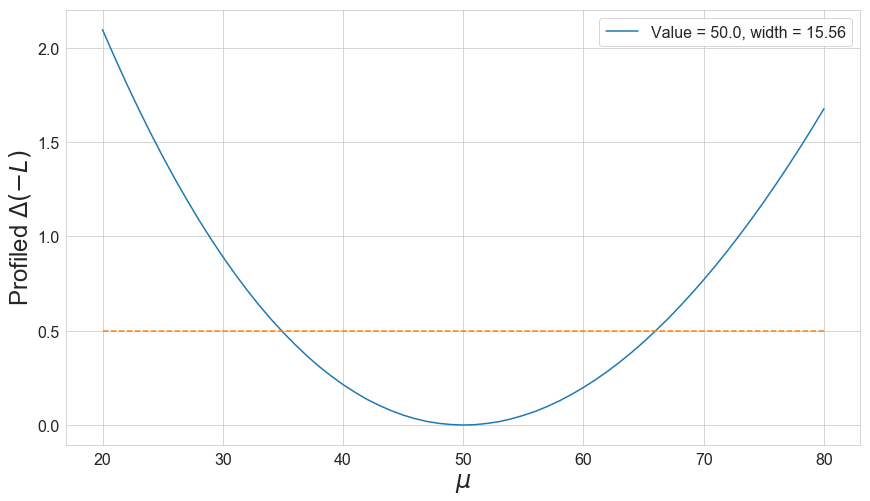

In [33]:
plot_likelihood(y-y.min())

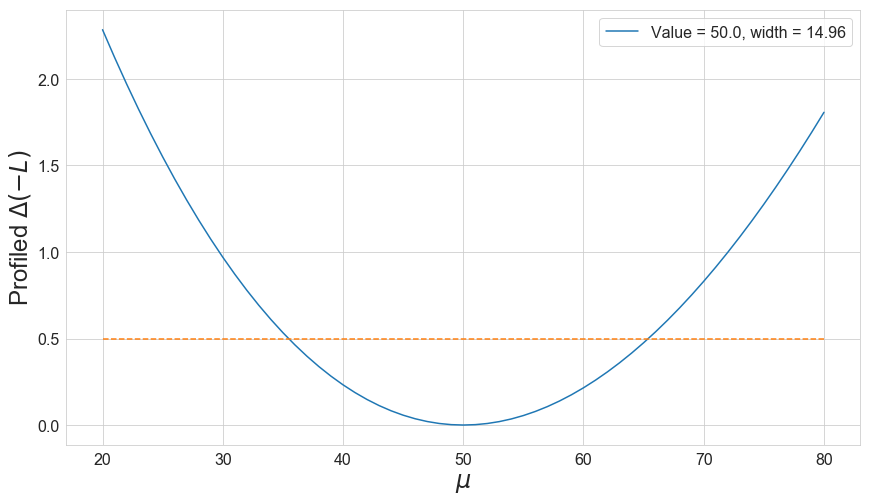

In [34]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [35]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [36]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [37]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,7,1.0,7,7,7,7,7,7,7,7,7,7,7
1,3,1.0,3,3,3,3,3,3,3,3,3,3,3
2,2,1.0,2,2,2,2,2,2,2,2,2,2,2
3,6,1.0,6,6,6,6,6,6,6,6,6,6,6
4,6,1.0,6,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,7,0.0,7,7,7,7,7,7,7,7,7,7,7
999996,7,0.0,7,7,7,7,7,7,7,7,7,7,7
999997,7,0.0,7,7,7,7,7,7,7,7,7,7,7
999998,7,0.0,7,7,7,7,7,7,7,7,7,7,7


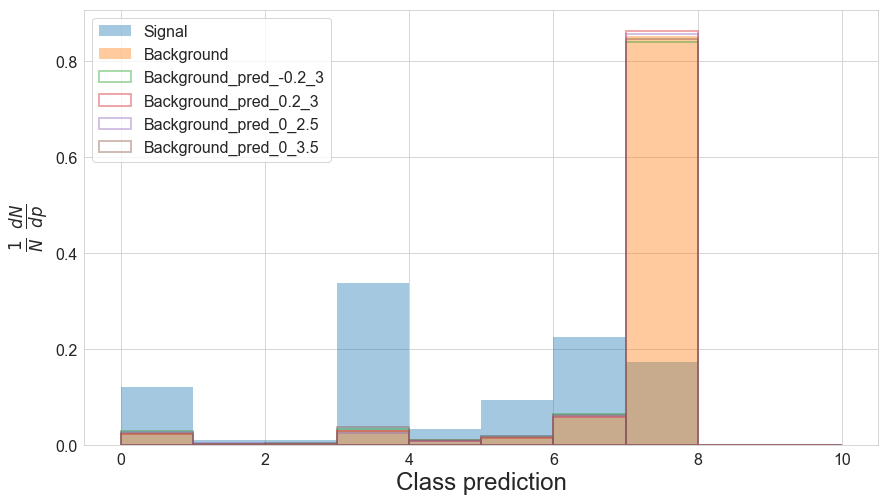

In [38]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([2.8910e-02, 2.9920e-03, 3.7280e-03, 2.8004e-02, 9.0500e-03, 1.9772e-02,
        6.2180e-02, 8.4536e-01, 2.0000e-13, 2.0000e-13])
tensor([2.8476e-02, 2.6320e-03, 3.2900e-03, 3.3860e-02, 9.4080e-03, 1.9098e-02,
        6.3320e-02, 8.3992e-01, 2.0000e-13, 2.0000e-13])
tensor([2.7984e-02, 2.3620e-03, 2.9620e-03, 3.9832e-02, 9.8540e-03, 1.8460e-02,
        6.4182e-02, 8.3436e-01, 2.0000e-13, 2.0000e-13])
tensor([2.6060e-02, 2.7580e-03, 3.3760e-03, 2.5474e-02, 8.2340e-03, 1.7412e-02,
        5.9586e-02, 8.5710e-01, 2.0000e-13, 2.0000e-13])
tensor([2.5626e-02, 2.3980e-03, 2.9380e-03, 3.1330e-02, 8.5920e-03, 1.6738e-02,
        6.0726e-02, 8.5165e-01, 2.0000e-13, 2.0000e-13])
tensor([2.5134e-02, 2.1280e-03, 2.6100e-03, 3.7302e-02, 9.0380e-03, 1.6100e-02,
        6.1588e-02, 8.4610e-01, 2.0000e-13, 2.0000e-13])
tensor([2.3568e-02, 2.5900e-03, 3.0240e-03, 2.2716e-02, 7.4420e-03, 1.5216e-02,
        5.6520e-02, 8.6892e-01, 2.0000e-13, 2.0000e-13])
tensor([2.3134e-02, 2.2300e-03, 2.5860e-0

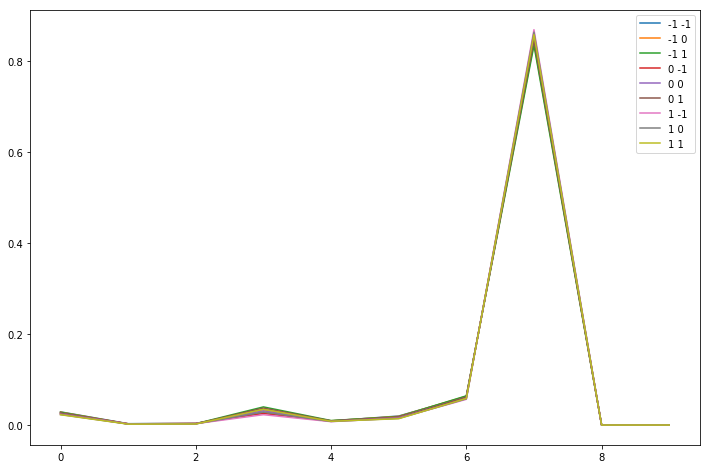

In [39]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [40]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [41]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [42]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [43]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

Linear regime: Mu 20.0, alpha tensor([-1.4884])
Linear regime: Mu 21.0, alpha tensor([-1.4370])
Linear regime: Mu 22.0, alpha tensor([-1.3857])
Linear regime: Mu 23.0, alpha tensor([-1.3345])
Linear regime: Mu 24.0, alpha tensor([-1.2835])
Linear regime: Mu 25.0, alpha tensor([-1.2326])
Linear regime: Mu 26.0, alpha tensor([-1.1819])
Linear regime: Mu 27.0, alpha tensor([-1.1312])
Linear regime: Mu 28.0, alpha tensor([-1.0807])
Linear regime: Mu 29.0, alpha tensor([-1.0303])
Linear regime: Mu 71.0, alpha tensor([1.0473])
Linear regime: Mu 72.0, alpha tensor([1.0963])
Linear regime: Mu 73.0, alpha tensor([1.1453])
Linear regime: Mu 74.0, alpha tensor([1.1942])
Linear regime: Mu 75.0, alpha tensor([1.2429])
Linear regime: Mu 76.0, alpha tensor([1.2917])
Linear regime: Mu 77.0, alpha tensor([1.3403])
Linear regime: Mu 78.0, alpha tensor([1.3889])
Linear regime: Mu 79.0, alpha tensor([1.4374])
Linear regime: Mu 80.0, alpha tensor([1.4859])


In [44]:
nll = to_np(nll)

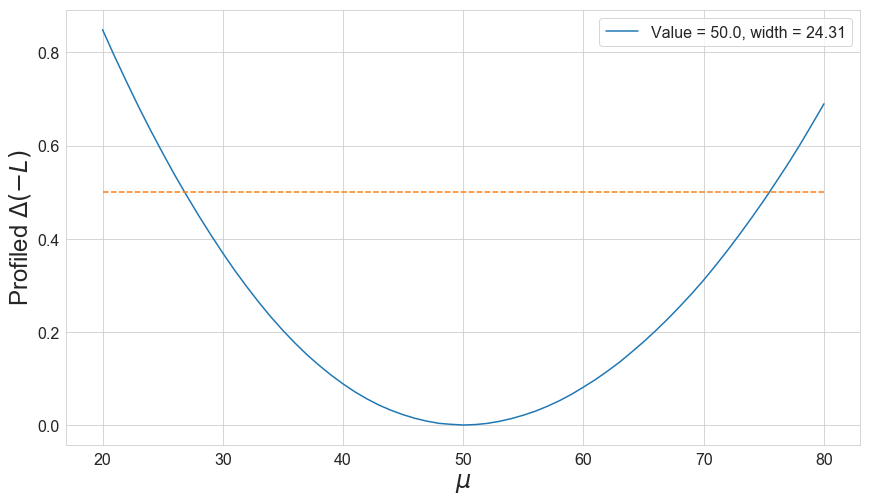

In [45]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [46]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [47]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

Linear regime: Mu 20.0, alpha tensor([1.2469])
Linear regime: Mu 21.0, alpha tensor([1.2070])
Linear regime: Mu 22.0, alpha tensor([1.1670])
Linear regime: Mu 23.0, alpha tensor([1.1269])
Linear regime: Mu 24.0, alpha tensor([1.0866])
Linear regime: Mu 25.0, alpha tensor([1.0462])
Linear regime: Mu 26.0, alpha tensor([1.0057])
Linear regime: Mu 74.0, alpha tensor([-1.0281])
Linear regime: Mu 75.0, alpha tensor([-1.0722])
Linear regime: Mu 76.0, alpha tensor([-1.1164])
Linear regime: Mu 77.0, alpha tensor([-1.1607])
Linear regime: Mu 78.0, alpha tensor([-1.2050])
Linear regime: Mu 79.0, alpha tensor([-1.2495])
Linear regime: Mu 80.0, alpha tensor([-1.2940])


In [48]:
nll = to_np(nll)

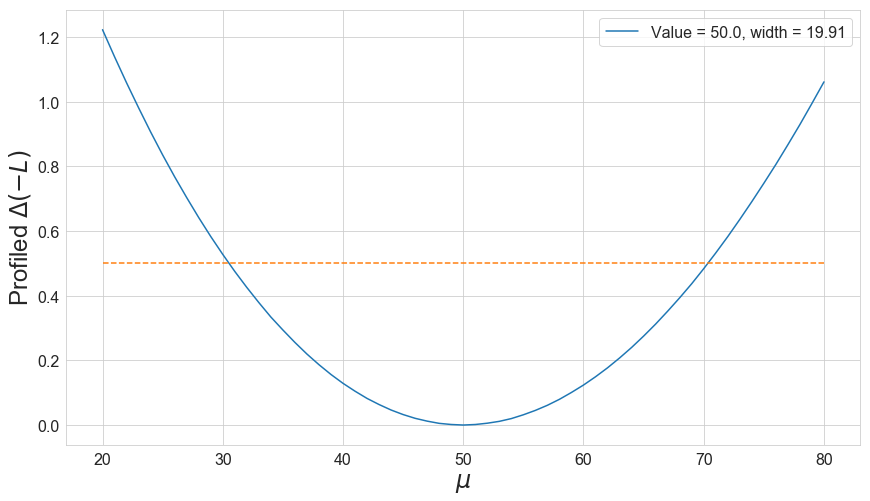

In [49]:
plot_likelihood(nll-nll.min())

## BM 2

In [50]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-1.1889,  0.9120])
Linear regime: Mu 21.0, alpha tensor([-1.1494,  0.8814])
Linear regime: Mu 22.0, alpha tensor([-1.1100,  0.8509])
Linear regime: Mu 23.0, alpha tensor([-1.0705,  0.8203])
Linear regime: Mu 24.0, alpha tensor([-1.0310,  0.7897])
Linear regime: Mu 74.0, alpha tensor([ 1.0036, -0.6454])
Linear regime: Mu 75.0, alpha tensor([ 1.0456, -0.6720])
Linear regime: Mu 76.0, alpha tensor([ 1.0876, -0.6985])
Linear regime: Mu 77.0, alpha tensor([ 1.1295, -0.7251])
Linear regime: Mu 78.0, alpha tensor([ 1.1715, -0.7516])
Linear regime: Mu 79.0, alpha tensor([ 1.2135, -0.7781])
Linear regime: Mu 80.0, alpha tensor([ 1.2555, -0.8045])


In [51]:
nll = to_np(nll)

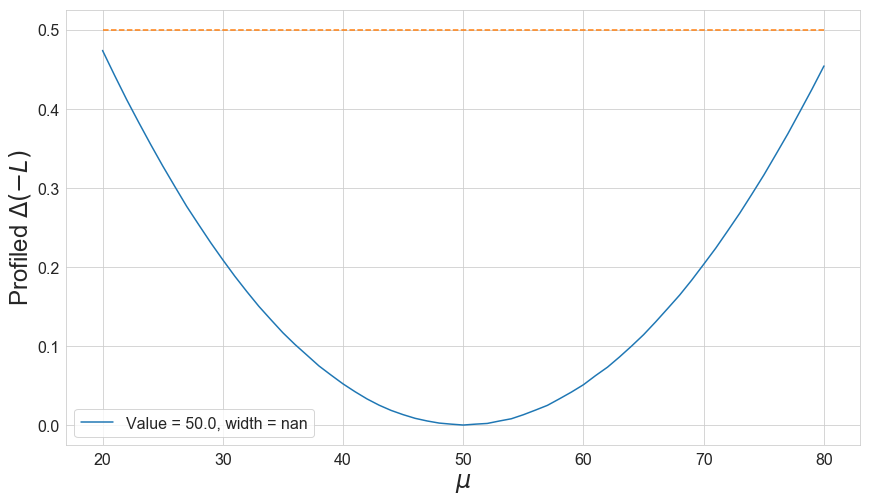

In [52]:
plot_likelihood(nll-nll.min())